In [ ]:
%%julia

## note that Julia has to be installed and available on $PATH and julia made available as a magic in Jupyter
## also make sure these packages are installed with Pkg.add("PACKAGE") in Julia:
using StatsBase
using Distributions
using StatsFuns
using Formatting

function clusterLikelihood(r::Float64,k::Float64,j::Int)
    """
    Likelihood derived from:
    Blumberg S, Lloyd-Smith JO (2013) 
    Inference of R0 and Transmission Heterogeneity from the Size Distribution of Stuttering Chains. 
    PLOS Computational Biology 9(5): e1002993. 
    https://doi.org/10.1371/journal.pcbi.1002993
    """
    
    c1 = lgamma(k*j+j-1)
    c2 = lgamma(k*j)
    c3 = lgamma(j+1)
    c4 = log((r/k)^(j-1))
    c5 = log((1+r/k)^(k*j+j-1))
    
    L=BigFloat(( c1 - ( c2 + c3 ) ) + ( c4 - c5 ))
    if isnan(L)
        L=-Inf
    elseif isinf(L)
        L=-Inf
    end
    return L
end;

function generateWeights(r::Float64,k::Float64,maxClusterSize::Int)
    """
    Generate sampling probabilities for clusters of a given size at given r0 and k.
    """
    raw=[e^clusterLikelihood(r,k,m) for m in 1:maxClusterSize] ## generate probability for sampling a cluster of a given size at different levels of r0 and k
    masked=[x for x in raw if isinf(x)==false] ## collect probabilities that aren't infinite
    sraw=1-sum(masked) ## assign remainder probability to class greater than maxClusterSize
    append!(raw,sraw) ## add probability
    
    probs=[]
    for x in raw
        if isinf(x) || isnan(x) ## if probability is infinite or NaN - make it 0.0
            append!(probs,0.0)
        else
            append!(probs,x)
        end
    end
    
    return probs
end;
        
function generateClusters(r::Float64,k::Float64,N::Int,loc_weights=[]::Array)
    """
    Generate clusters at a given r0 and k until an outbreak of size N is reached.
    Can optionally provide sampling probabilities if they were pre-computed.
    """
    if length(loc_weights)==0 || sum(loc_weights)<0 ## if sampling probabilities were not provided
        loc_weights=generateWeights(r,k,N) ## generate sampling probabilities
    end

    clusters=sample(1:N+1, WeightVec(map(Float64,loc_weights)),N) ## draw N clusters at random
    if clusters[1]>N ## if first generated cluster greater than maximum outbreak size
        clusters=[N] ## first generated cluster is of size N
    else
        clusters=[clusters[i] for i in 1:length(clusters) if sum(clusters[1:i])<=N] ## generate clusters until just below outbreak size N
        append!(clusters,N-sum(clusters)) ## add remainder cluster
    end
    
    return clusters,loc_weights
end;

function MultivariateHypergeometricSampleBias(n::Int,D::Array,bias::Float64)
    N = sum(D) ## total cases = pool
    m = length(D) ## indexing
    n_otr = N-D[1] ## things left to sequence
        
    if length(D)==1
        x=[n]
    else
        x = zeros(Int64,m)
        x[1] = rand(Hypergeometric(D[1],n_otr,n)) ## starting draw
        for i = 2:m-1
            n_otr = n_otr-D[i] ## total pool reduced after sequencing/testing
            n = n-x[i-1] ## fewer resources left to sequence
            
            HGD=Hypergeometric(D[i],n_otr,n)
            weights=[w^bias for w in pdf(HGD,0:n)]
            x[i] = sample(0:n,WeightVec(weights/sum(weights))) ## biased draws from hypergeometric
        end
        x[m] = n-x[m-1]
    end
    return x
end;
    
function clusterProbBias(seqN::Int,r::Float64,k::Float64,N::Int,reps::Int,bias::Float64)
    ws=generateWeights(r,k,N) ## generate probabilities
    case_clusters=[generateClusters(r,k,N,ws)[1] for w = 1:reps] ## generate replicated clusters
    sequence_clusters=[MultivariateHypergeometricSampleBias(seqN,C,float(bias)) for C in case_clusters]
    return case_clusters,sequence_clusters
end;

human_sequences=174
human_cases=2000
human_clusters=[7, 2, 1, 1, 1, 1, 1, 19, 1, 1, 3, 1, 29, 1, 1, 1, 2, 1, 1, 1, 1, 1, 6, 18, 1, 1, 1, 1, 1, 2, 2, 3, 5, 2, 1, 1, 4, 1, 1, 15, 1, 4, 13, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]

reps=2000
for bias in 1:3
    for r = 0.5:0.025:1.05
        for k = [0.004, 0.02, 0.1, 0.5, 1.0]
            R=@sprintf("r_%0.3f", r)
            K=@sprintf("k_%0.3f", k)
            B="b_$bias"
            samples=open("$B/$K/$R/MERS_epi_$reps.txt","w")
            cases,sequences=clusterProbBias(human_sequences,r,k,human_cases,reps,Float64(bias))
            
            for (s,c) in zip(cases,sequences)
                out = @sprintf "%s\t%s\n" s c
                write(samples,out)
            end;
            close(samples)
        end;
    end;
end;

human_sequences=174
human_cases=2000
human_clusters=[7, 2, 1, 1, 1, 1, 1, 19, 1, 1, 3, 1, 29, 1, 1, 1, 2, 1, 1, 1, 1, 1, 6, 18, 1, 1, 1, 1, 1, 2, 2, 3, 5, 2, 1, 1, 4, 1, 1, 15, 1, 4, 13, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]

reps=2500
k=0.1
for bias in 1:3
    for r = linspace(0.5,1.1,121)
        R=string(r)
        samples=open("MERS_epi_bias_$bias.$R.1.2500r.2000c.txt","w")
#         samples=open("MERS_epi_bias_$bias.$R.1.2500r.4000c.txt","w")
#         samples=open("MERS_epi_bias_$bias.$R.5.2500r.2000c.txt","w")
        cases,sequences=clusterProbBias(human_sequences,r,k,human_cases,reps,Float64(bias))

        for (s,c) in zip(cases,sequences)
            out = @sprintf "%s\t%s\n" s c
            write(samples,out)
        end;
        close(samples)
    end;
end;

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import re
from matplotlib import gridspec
import matplotlib.patheffects as path_effects
from IPython.display import HTML
from scipy.stats import gaussian_kde
from scipy.stats import hypergeom
from scipy.stats import moment

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

path='<iframe style="border: 0; width: 400px; height: 439px;" src="https://bandcamp.com/EmbeddedPlayer/album=2862067915/size=large/bgcol=333333/linkcol=e99708/artwork=small/transparent=true/" seamless><a href="http://pulverised.bandcamp.com/album/the-infernal-gospels-of-primitive-devil-worship">The Infernal Gospels Of Primitive Devil Worship by Beastcraft</a></iframe>'

def hpd(data, level):
    """
    Return highest posterior density interval from a list,
    given the percent posterior density interval required.
    """
    d = list(data)
    d.sort()

    nData = len(data)
    nIn = int(round(level * nData))
    if nIn < 2 :
        return None
    #raise RuntimeError("Not enough data. N data: %s"%(len(data)))
 
    i = 0
    r = d[i+nIn-1] - d[i]
    for k in range(len(d) - (nIn - 1)) :
        rk = d[k+nIn-1] - d[k]
        if rk < r :
            r = rk
            i = k

    assert 0 <= i <= i+nIn-1 < len(d)
 
    return (d[i], d[i+nIn-1])

print 'Done!'
HTML(path)

Done!


In [2]:
data={1:{},2:{},3:{}} ## levels of bias

for f in os.listdir('/Users/evogytis/Dropbox/Jupyter_notebooks/MCMC/'):
    #print f
    if '_1' in f:
        idx=1
    elif '_2' in f:
        idx=2
    elif '_3' in f:
        idx=3
        
#     if f.endswith('.2000c.txt'):
#         cerberus=re.match('[A-Z\_a-z]+\_[0-9]+\.([0-9\.]+)\.[0-9]+\.[0-9\.]+r\.2000c.txt',f)
#         indices=set(np.random.choice(xrange(2000),size=2000,replace=False)) ## subsample indices
#         MERS_epi_bias_1.0.5.5.2500r.2000c.txt
#     if f.endswith('.4000c.txt'):
#         indices=set(np.random.choice(xrange(4000),size=3000,replace=False)) ## subsample indices
#         cerberus=re.match('[A-Z\_a-z]+\_[0-9]+\.([0-9\.]+)\.[0-9\.]+r\.4000c.txt',f)
    if f.endswith('.25k.txt'):
        indices=set(np.random.choice(xrange(25000),size=3000,replace=False)) ## subsample indices for the 25k simulations
        cerberus=re.match('[A-Z\_a-z]+\_[0-9]+\.([0-9\.]+)\.25k.txt',f)
        
        r=cerberus.group(1)
        data[idx][r]=[]
        print f,r
        counter=0
        for line in open('/Users/evogytis/Dropbox/Jupyter_notebooks/MCMC/'+f,'r'):
            if len(set([counter])&indices)==1:
                l=line.strip('\n').split('\t')
                #print l
                cases,sequences=l
                cases=map(int,cases[1:-1].split(','))
                sequences=map(int,sequences[1:-1].split(','))

                data[idx][r].append((cases,sequences))
                
            counter+=1

MERS_epi_bias_1.0.5.25k.txt 0.5
MERS_epi_bias_1.0.505.25k.txt 0.505
MERS_epi_bias_1.0.51.25k.txt 0.51
MERS_epi_bias_1.0.515.25k.txt 0.515
MERS_epi_bias_1.0.52.25k.txt 0.52
MERS_epi_bias_1.0.525.25k.txt 0.525
MERS_epi_bias_1.0.53.25k.txt 0.53
MERS_epi_bias_1.0.535.25k.txt 0.535
MERS_epi_bias_1.0.54.25k.txt 0.54
MERS_epi_bias_1.0.545.25k.txt 0.545
MERS_epi_bias_1.0.55.25k.txt 0.55
MERS_epi_bias_1.0.555.25k.txt 0.555
MERS_epi_bias_1.0.56.25k.txt 0.56
MERS_epi_bias_1.0.565.25k.txt 0.565
MERS_epi_bias_1.0.57.25k.txt 0.57
MERS_epi_bias_1.0.575.25k.txt 0.575
MERS_epi_bias_1.0.58.25k.txt 0.58
MERS_epi_bias_1.0.585.25k.txt 0.585
MERS_epi_bias_1.0.59.25k.txt 0.59
MERS_epi_bias_1.0.595.25k.txt 0.595
MERS_epi_bias_1.0.6.25k.txt 0.6
MERS_epi_bias_1.0.605.25k.txt 0.605
MERS_epi_bias_1.0.61.25k.txt 0.61
MERS_epi_bias_1.0.615.25k.txt 0.615
MERS_epi_bias_1.0.62.25k.txt 0.62
MERS_epi_bias_1.0.625.25k.txt 0.625
MERS_epi_bias_1.0.63.25k.txt 0.63
MERS_epi_bias_1.0.635.25k.txt 0.635
MERS_epi_bias_1.0.64.25k

MERS_epi_bias_2.1.075.25k.txt 1.075
MERS_epi_bias_2.1.08.25k.txt 1.08
MERS_epi_bias_2.1.085.25k.txt 1.085
MERS_epi_bias_2.1.09.25k.txt 1.09
MERS_epi_bias_2.1.095.25k.txt 1.095
MERS_epi_bias_2.1.1.25k.txt 1.1
MERS_epi_bias_3.0.5.25k.txt 0.5
MERS_epi_bias_3.0.505.25k.txt 0.505
MERS_epi_bias_3.0.51.25k.txt 0.51
MERS_epi_bias_3.0.515.25k.txt 0.515
MERS_epi_bias_3.0.52.25k.txt 0.52
MERS_epi_bias_3.0.525.25k.txt 0.525
MERS_epi_bias_3.0.53.25k.txt 0.53
MERS_epi_bias_3.0.535.25k.txt 0.535
MERS_epi_bias_3.0.54.25k.txt 0.54
MERS_epi_bias_3.0.545.25k.txt 0.545
MERS_epi_bias_3.0.55.25k.txt 0.55
MERS_epi_bias_3.0.555.25k.txt 0.555
MERS_epi_bias_3.0.56.25k.txt 0.56
MERS_epi_bias_3.0.565.25k.txt 0.565
MERS_epi_bias_3.0.57.25k.txt 0.57
MERS_epi_bias_3.0.575.25k.txt 0.575
MERS_epi_bias_3.0.58.25k.txt 0.58
MERS_epi_bias_3.0.585.25k.txt 0.585
MERS_epi_bias_3.0.59.25k.txt 0.59
MERS_epi_bias_3.0.595.25k.txt 0.595
MERS_epi_bias_3.0.6.25k.txt 0.6
MERS_epi_bias_3.0.605.25k.txt 0.605
MERS_epi_bias_3.0.61.25k.t

In [3]:
log_path='/Users/evogytis/Documents/MERS_2.0/clean/analyses/beast/coal/MERS_274_sCoal.combined.subtrees'
posts={}
empirical_clusters=[]
for line in open(log_path,'r'):
    l=line.strip('\n').split('\t')
    if 'state' not in l:
        empirical_clusters.append([stree.count(',')+1 for stree in l])
        
posts['mean']=map(np.mean,empirical_clusters)
posts['std']=map(np.std,empirical_clusters)
posts['third']=[moment(clusters,moment=3) for clusters in empirical_clusters]
posts['N']=map(len,empirical_clusters)

In [4]:
hpds={}        
for idx in posts.keys():
    hpds[idx]=hpd(posts[idx],0.95)

print hpds
sl,su=hpds['std']
ml,mu=hpds['mean']
tl,tu=hpds['third']
ll,lu=hpds['N']

matches={idx:{r:[] for r in data[idx].keys()} for idx in data.keys()}
mismatches={idx:{r:[] for r in data[idx].keys()} for idx in data.keys()}
match_indices={idx:{r:[] for r in data[idx].keys()} for idx in data.keys()}

norm=mpl.colors.Normalize(0.5,1.1)
for idx in data.keys():

    for r in data[idx].keys():
        cs=[x[0] for x in data[idx][r]]
        ss=[filter(lambda w:w!=0,x[1]) for x in data[idx][r]]
    
        ## sequence cluster stats
        stds=map(np.std,ss)
        mus=map(np.mean,ss)
        meds=map(np.median,ss)
        thirds=[moment(clusters,moment=3) for clusters in ss]
        lens=map(len,ss)
        
        clens=map(len,cs) ## intros (case cluster lengths)
        
#         ms=filter(lambda q:sl<stds[q]<=su and ml<mus[q]<=mu and ll<lens[q]<=lu and meds[q]==1,[i for i,x in enumerate(zip(stds,mus,meds,lens,clens))]) ## medians
#         ms=filter(lambda q:sl<stds[q]<=su and ml<mus[q]<=mu and ll<lens[q]<=lu,[i for i,x in enumerate(zip(stds,mus,lens,clens))]) ## no medians
        ms=filter(lambda q:sl<stds[q]<=su and ml<mus[q]<=mu and ll<lens[q]<=lu and tl<thirds[q]<=tu,[i for i,x in enumerate(zip(stds,mus,meds,lens,thirds,clens))]) ## stdevs, means, N clusters, third moments
        
        for i in range(len(stds)):
            if i in ms:
                matches[idx][r].append((stds[i],mus[i],lens[i],thirds[i],clens[i],ss[i]))
                match_indices[idx][r].append(i)
            else:
                mismatches[idx][r].append((stds[i],mus[i],lens[i],thirds[i],clens[i],ss[i]))
        print r

{'std': (4.8383594556649276, 6.0237624692308618), 'mean': (2.8688524590163933, 3.6458333333333335), 'third': (415.4018181021429, 621.05591246640938), 'N': (48, 61)}
0.745
0.965
0.585
0.915
1.015
0.515
0.845
0.695
0.5
1.005
1.01
0.735
0.59
0.58
0.51
0.53
0.52
0.55
0.54
0.57
0.56
0.995
1.03
1.02
1.05
1.04
1.07
0.505
1.09
0.855
1.06
0.625
1.095
1.08
0.645
1.035
0.725
0.905
0.985
0.535
0.825
0.635
1.085
0.98
0.655
1.025
0.935
0.96
0.525
0.835
0.925
0.665
0.885
1.055
0.805
1.1
0.795
0.82
0.83
0.715
0.81
0.86
0.87
0.84
0.85
0.555
0.88
0.89
0.775
0.955
0.675
0.895
1.045
0.815
0.785
0.99
0.705
0.95
0.94
0.97
0.545
0.91
0.93
0.92
0.9
0.8
0.765
1.0
1.075
0.945
0.605
0.7
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.865
0.575
0.755
0.975
0.595
0.615
0.73
0.72
0.71
0.77
0.76
0.75
0.74
1.065
0.79
0.78
0.565
0.875
0.685
0.745
0.965
0.585
0.915
1.015
0.515
0.845
0.695
0.5
1.005
1.01
0.735
0.59
0.58
0.51
0.53
0.52
0.55
0.54
0.57
0.56
0.995
1.03
1.02
1.05
1.04
1.07
0.505
1.09
0.855
1.06
0.625
1.09

1 121
R0 percentiles: (0.70,0.97) median: 0.83 mean: 0.84 supporting sims: 1058
introductions percentiles: (264,448) median: 344 mean: 347.82 supporting sims: 1058
2 121
R0 percentiles: (0.60,0.87) median: 0.72 mean: 0.73 supporting sims: 4205
introductions percentiles: (432,730) median: 567 mean: 569.86 supporting sims: 4205
3 121
R0 percentiles: (0.55,0.82) median: 0.68 mean: 0.68 supporting sims: 4122
introductions percentiles: (491,847) median: 654 mean: 660.01 supporting sims: 4122
model averaged: 0.72 (0.57-0.90) 584.43 (311.00-816.00)


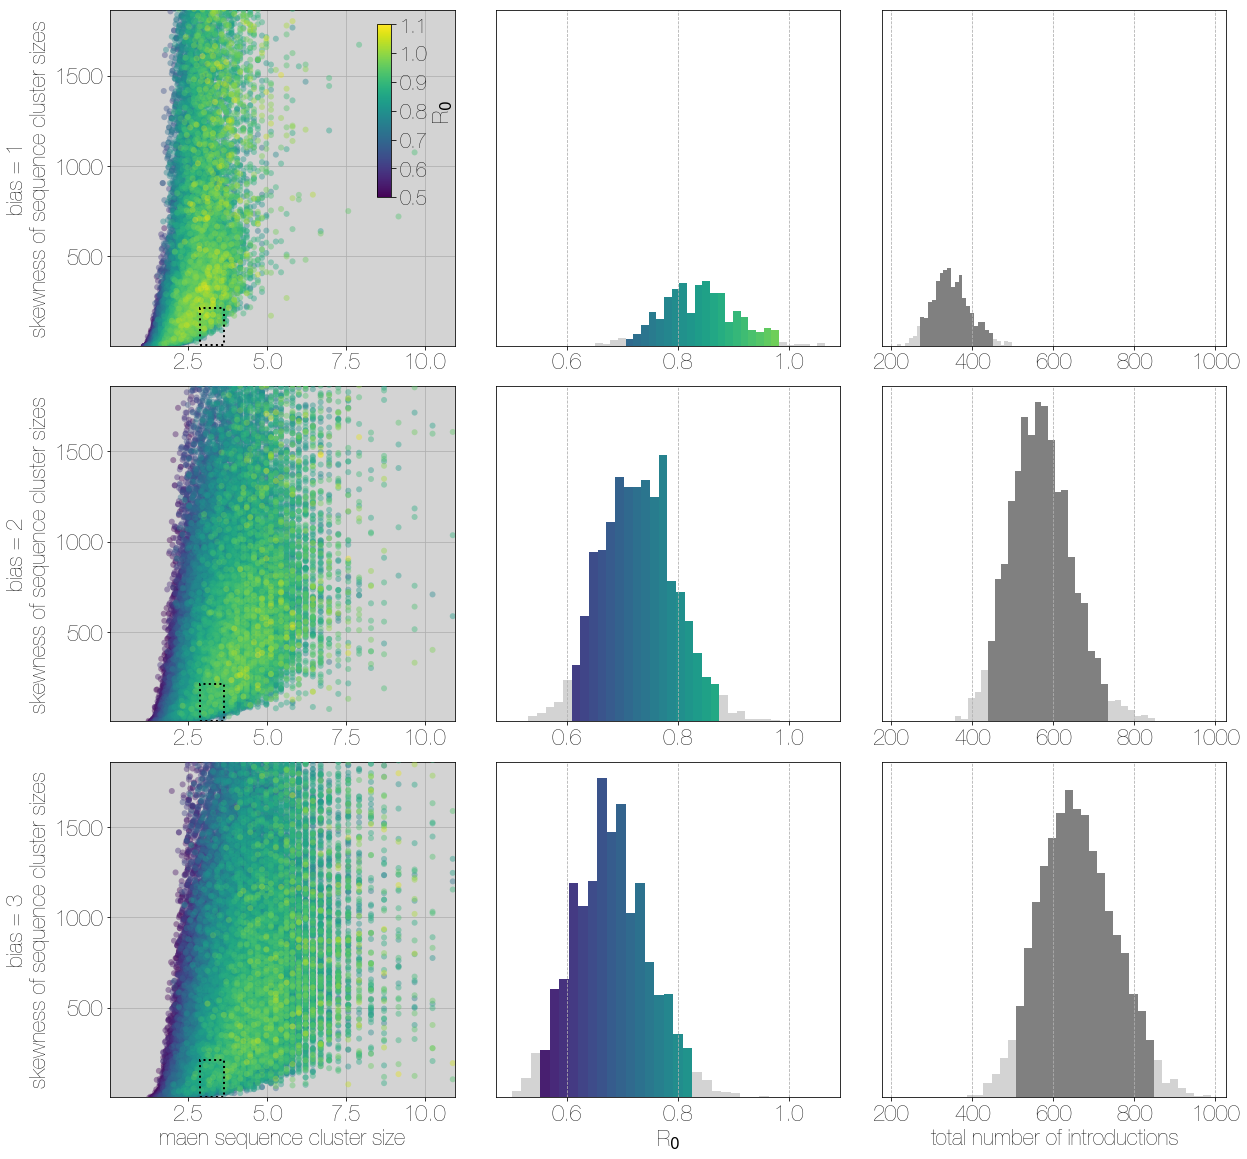

In [10]:
fig = plt.figure(figsize=(20,20),facecolor='w')
gs = gridspec.GridSpec(3, 3,width_ratios=[1,1,1],hspace=0.12,wspace=0.12)

ax1=plt.subplot(gs[0,0])
ax1.set_facecolor('lightgrey')
ax2=plt.subplot(gs[0,1])
ax3=plt.subplot(gs[0,2])

bx1=plt.subplot(gs[1,0],sharex=ax1)
bx1.set_facecolor('lightgrey')
bx2=plt.subplot(gs[1,1],sharex=ax2,sharey=ax2)
bx3=plt.subplot(gs[1,2],sharex=ax3,sharey=ax3)

cx1=plt.subplot(gs[2,0],sharex=ax1)
cx1.set_facecolor('lightgrey')
cx2=plt.subplot(gs[2,1],sharex=ax2,sharey=ax2)
cx3=plt.subplot(gs[2,2],sharex=ax3,sharey=ax3)

for idx in sorted(data.keys()):
    print idx,len(data[idx])
    if idx==1:
        zx1,zx2,zx3=ax1,ax2,ax3
    elif idx==2:
        zx1,zx2,zx3=bx1,bx2,bx3
    else:
        zx1,zx2,zx3=cx1,cx2,cx3
        
    intros=[]
    
    sl,su=hpds['std']
    ml,mu=hpds['mean']
    tl,tu=hpds['third']
    
    match_rectangle=plt.Rectangle((ml,sl),mu-ml,tu-tl,facecolor='none',edgecolor='k',lw=2,ls=':',zorder=10000)
    zx1.add_patch(match_rectangle)
    
#     match_rectangle=plt.Rectangle((sl,tl),su-sl,tu-tl,facecolor='none',edgecolor='k',lw=2,ls=':',zorder=10000)
#     zx1.add_patch(match_rectangle)
    
    cmap=mpl.cm.viridis
    
    R0s=[]
    for r in matches[idx].keys():
        xs=[x[1] for x in matches[idx][r]] ## means
#         xs=[x[0] for x in matches[idx][r]] ## stdevs
        ys=[x[3] for x in matches[idx][r]] ## third moments
        intros+=[x[-2] for x in matches[idx][r]] ## intros
        
        zx1.scatter(xs,ys,facecolor=cmap(norm(float(r))),edgecolor='none',alpha=0.4,
                  zorder=int(float(r)*1000))
        R0s+=[float(r) for x in xs] ## store R0 values
    
    lc,uc=np.percentile(R0s,[2.5,97.5])
    n,bins,patches=zx2.hist(R0s,bins=30,facecolor='grey')
    
    print 'R0 percentiles: (%.2f,%.2f) median: %.2f mean: %.2f supporting sims: %d'%(lc,uc,np.median(R0s),np.mean(R0s),sum(n))
    
    for b,p in zip(bins,patches):
        if b<lc or b>uc:
            p.set_facecolor('lightgrey')
        else:
            p.set_facecolor(cmap(norm(b)))
    
    li,ui=np.percentile(intros,[2.5,97.5])
    n,bins,patches=zx3.hist(intros,bins=30,facecolor='grey')
    
    print 'introductions percentiles: (%d,%d) median: %d mean: %.2f supporting sims: %d'%(li,ui,np.median(intros),np.mean(intros),sum(n))
    
    for b,p in zip(bins,patches):
        if b<li or b>ui:
            p.set_facecolor('lightgrey')
            
    for r in mismatches[idx].keys():
        xs=[x[1] for x in mismatches[idx][r]] ## means
#         xs=[x[0] for x in mismatches[idx][r]] ## stdevs
        ys=[x[3] for x in mismatches[idx][r]] ## third moments
        zx1.scatter(xs,ys,facecolor=cmap(norm(float(r))),edgecolor='none',alpha=0.4,
                   zorder=int(float(r)*1000))
        
#     zx1.set_xlim(0,10)
#     zx1.set_ylim(0,30)
#     zx2.set_xlim(0.5,1.1)

#     zx1.set_xlim(0,15) ## stdev
#     zx1.set_ylim(0,5000) ## third moments
    zx1.set_xlim(ml*0.01,mu*3.0)
    zx1.set_ylim(tl*0.01,tu*3.0)
    
    zx1.grid()
    zx2.grid(axis='x',ls='--')
    zx3.grid(axis='x',ls='--')
    
    #zx1.set_ylabel('bias = %d\nsequence cluster st dev'%(idx))
    zx1.set_ylabel('bias = %d\nskewness of sequence cluster sizes'%(idx))
    
    if idx==3:
        zx1.set_xlabel('maen sequence cluster size')
        zx2.set_xlabel('R$_{0}$')
        zx3.set_xlabel('total number of introductions')
    
    zx2.set_yticklabels([])
    zx3.set_yticklabels([])
    
    zx2.tick_params(axis='y',size=0)
    zx3.tick_params(axis='y',size=0)

averaged_R0=[]
averaged_intros=[]

for idx in sorted(data.keys()):   
    for r in matches[idx].keys():
        xs=[x[1] for x in matches[idx][r]] ## mus

        averaged_intros+=[x[-2] for x in matches[idx][r]] ## intros
        averaged_R0+=[float(r) for x in xs]

rl,ru=np.percentile(averaged_R0,[2.5,97.5])
il,iu=np.percentile(averaged_intros,[2.5,97.5])
print 'model averaged: %.2f (%.2f-%.2f) %.2f (%.2f-%.2f)'%(np.mean(averaged_R0),rl,ru,np.mean(averaged_intros),il,iu)

cb = fig.add_axes([0.31, 0.75, 0.01, 0.12])
mpl.colorbar.ColorbarBase(cb, cmap=cmap,ticks=np.linspace(0.5,1.1,7),norm=norm)
cb.tick_params(size=5,labelsize=20)
cb.set_ylabel('R$_{0}$')
plt.savefig('/Users/evogytis/Documents/structured-mers/figures/mers_epi.png',dpi=300,bbox_inches='tight') ## save to file
# plt.savefig('/Users/evogytis/Documents/structured-mers/figures/mers_epi_4000c.png',dpi=300,bbox_inches='tight')
#plt.savefig('/Users/evogytis/Documents/structured-mers/figures/mers_epi.pdf',dpi=300,bbox_inches='tight')
plt.show()

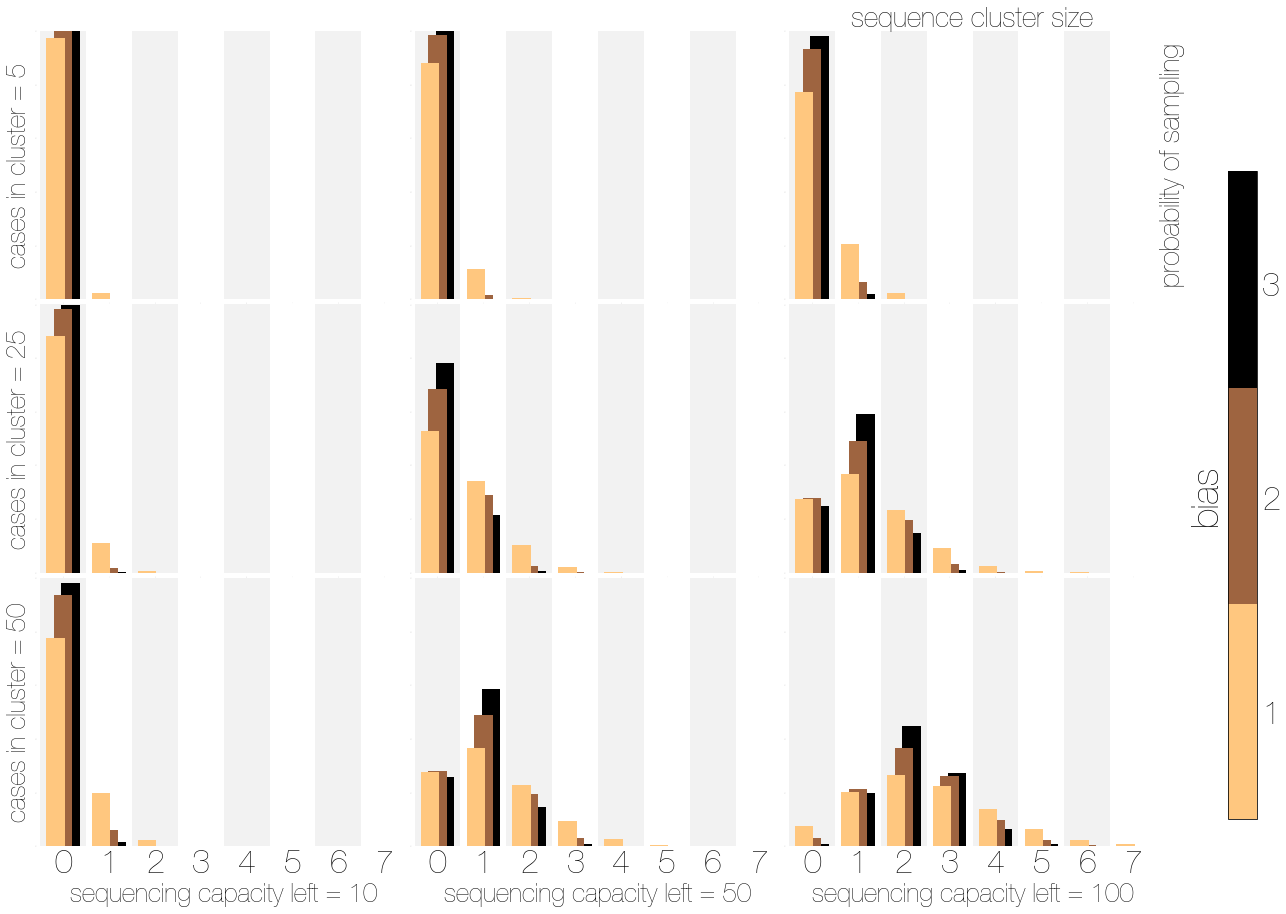

In [5]:
total=2000
biases=[1,2,3]
caseClusterSizes=[5,25,50] ## successes
sequencesAvailable=[10,50,100] ## sequencing capacity left

fig = plt.figure(figsize=(20,15),facecolor='w')
gs = gridspec.GridSpec(len(caseClusterSizes), len(sequencesAvailable),hspace=0.02,wspace=0.02)

cmap=mpl.cm.copper_r
bounds=[1,2,3,4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for i,S in enumerate(caseClusterSizes):
    for j,T in enumerate(sequencesAvailable):
        ax=plt.subplot(gs[i,j])
        
        
        rv = hypergeom(total, S, T)
        C = np.arange(0, 8)
        
        hmap=np.zeros((len(biases),len(C)))
        
        for y,bias in enumerate(biases):
            hgm_pmf = rv.pmf(C)
            hgm_pmf=np.power(hgm_pmf,bias)
            hgm_pmf=hgm_pmf/hgm_pmf.sum()

            for p,prob in enumerate(hgm_pmf):
                hmap[y][p]=hgm_pmf[p]

            ax.bar([x+(y-1)/6.0 for x in C],hgm_pmf,facecolor=cmap(norm(bias)),edgecolor='none',align='center',zorder=5-bias,width=0.4)

        ax.set_xticks(C)

        ax.set_xticklabels(C)
        
        if j==0:
            ax.set_ylabel('cases in cluster = %d'%(S),size=26)
            ax.tick_params(axis='y',labelsize=32)
        else:
            ax.tick_params(axis='y',labelsize=0)
            
        if i==len(caseClusterSizes)-1:
            ax.set_xlabel('sequencing capacity left = %d'%(T),size=26)
            ax.tick_params(axis='x',labelsize=32)
        else:
            ax.tick_params(axis='x',labelsize=0)
            
        if i==0 and j==len(sequencesAvailable)-1:
            ax.xaxis.set_label_position('top')
            ax.yaxis.set_label_position('right')
            
            ax.set_xlabel('sequence cluster size',size=28)
            ax.set_ylabel('probability of sampling',size=28)
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        ax.tick_params(size=0)
        ax.tick_params(axis='y',labelsize=0)
        
        ax.set_ylim(0,1)
        ax.set_xlim(min(C)-0.5,max(C)+0.5)

        [ax.axvspan(x-0.5,x+0.5,facecolor='k',edgecolor='none',alpha=0.05) for x in range(0,len(C),2)]
        
axcb = fig.add_axes([0.95, 0.15, 0.02, 0.6], frame_on=False)
cb=mpl.colorbar.ColorbarBase(axcb,cmap=cmap,norm=norm,orientation='vertical',alpha=1.0)

axcb.yaxis.set_ticks(np.linspace(0.165,0.825,3))
axcb.yaxis.set_ticklabels(biases)
axcb.yaxis.set_label_position("left")
axcb.tick_params(axis='y',which='both',direction='out',size=0,labelsize=32,width=1,pad=5)

axcb.set_ylabel('bias',{'fontsize':38})

plt.show()